In [ ]:
!nvidia-smi

Fri Dec 11 21:04:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 9.5MB/s 
     |████████████████████████████████| 890kB 28.8MB/s 
     |████████████████████████████████| 2.9MB 47.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=b19bc18b8157088539e480810419403253c6dd28ad4de202e749a1b44dfbfa21
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Exploration


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MLProject/Data/train.csv', encoding='latin1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df.shape

(41157, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
def sentiment_to_value(sentiment):
  if sentiment == 'Extremely Negative':
    return 0
  if sentiment == 'Negative':
    return 1
  if sentiment == 'Neutral':
    return 2
  if sentiment == 'Positive':
    return 3
  if sentiment == 'Extremely Positive':
    return 4

In [ ]:
class_names = ['Extremely Negative','Negative','Neutral','Positive','Extremely Positive']
df['Class'] = df['Sentiment'].apply(sentiment_to_value)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Extremely Negative'),
 Text(0, 0, 'Negative'),
 Text(0, 0, 'Neutral'),
 Text(0, 0, 'Positive'),
 Text(0, 0, 'Extremely Positive')]

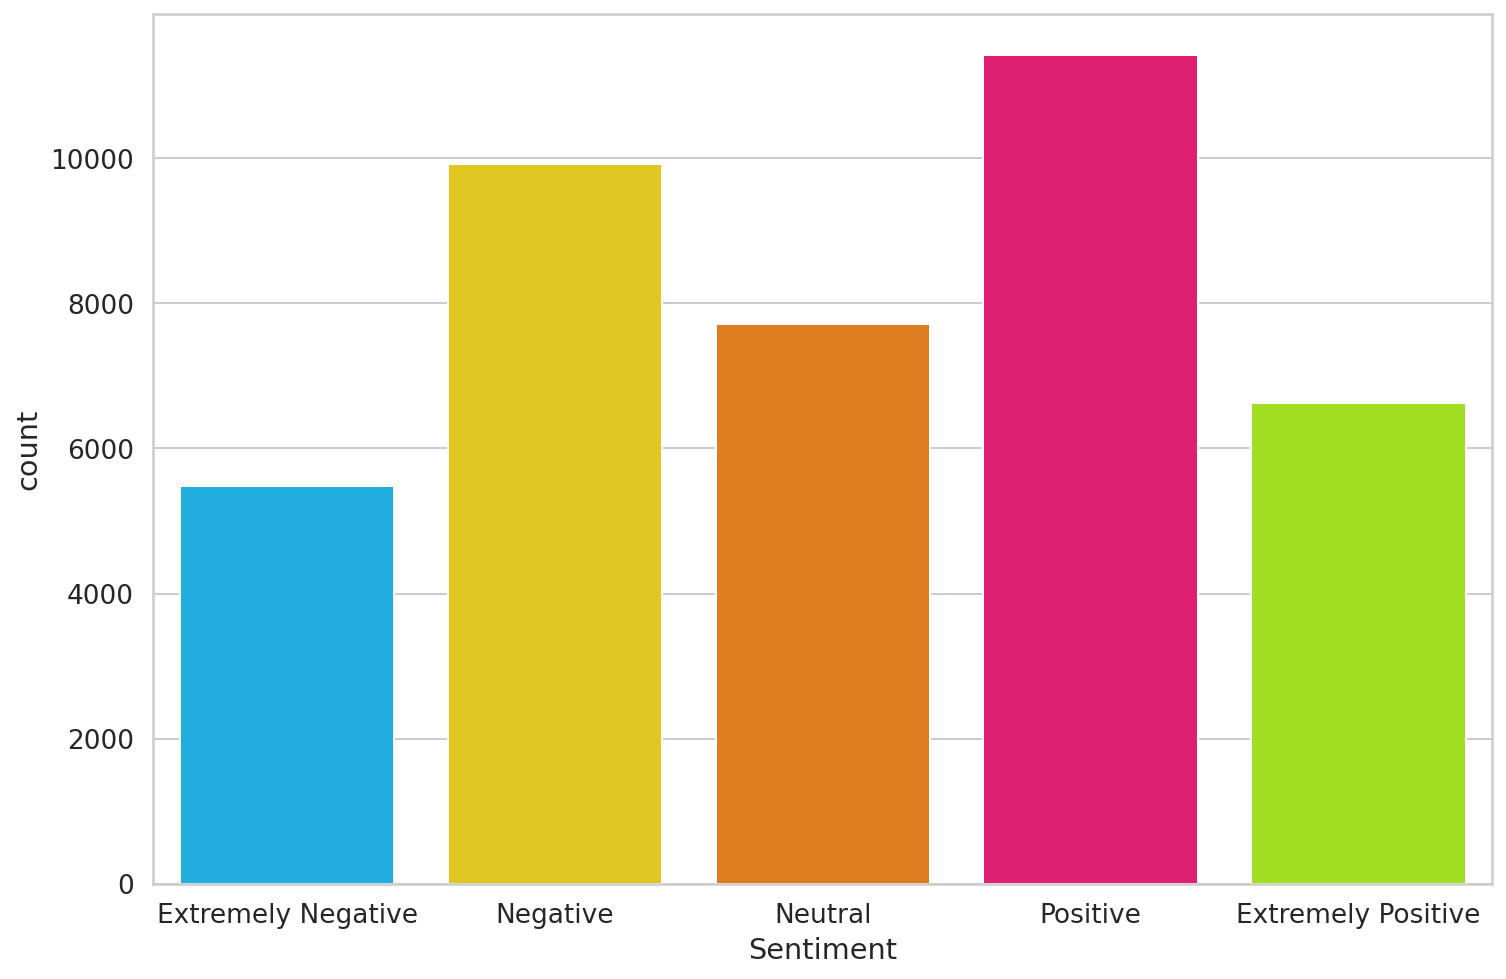

In [ ]:
ax = sns.countplot(df['Class'])
plt.xlabel('Sentiment')
ax.set_xticklabels(class_names)

#Data Preprocessing


In [ ]:
Batch_Size = 16
Epochs = 20
Max_Length = 160

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME) # Casing is important in sentiment analysis.

## Deciding the MAX_LENGTH

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


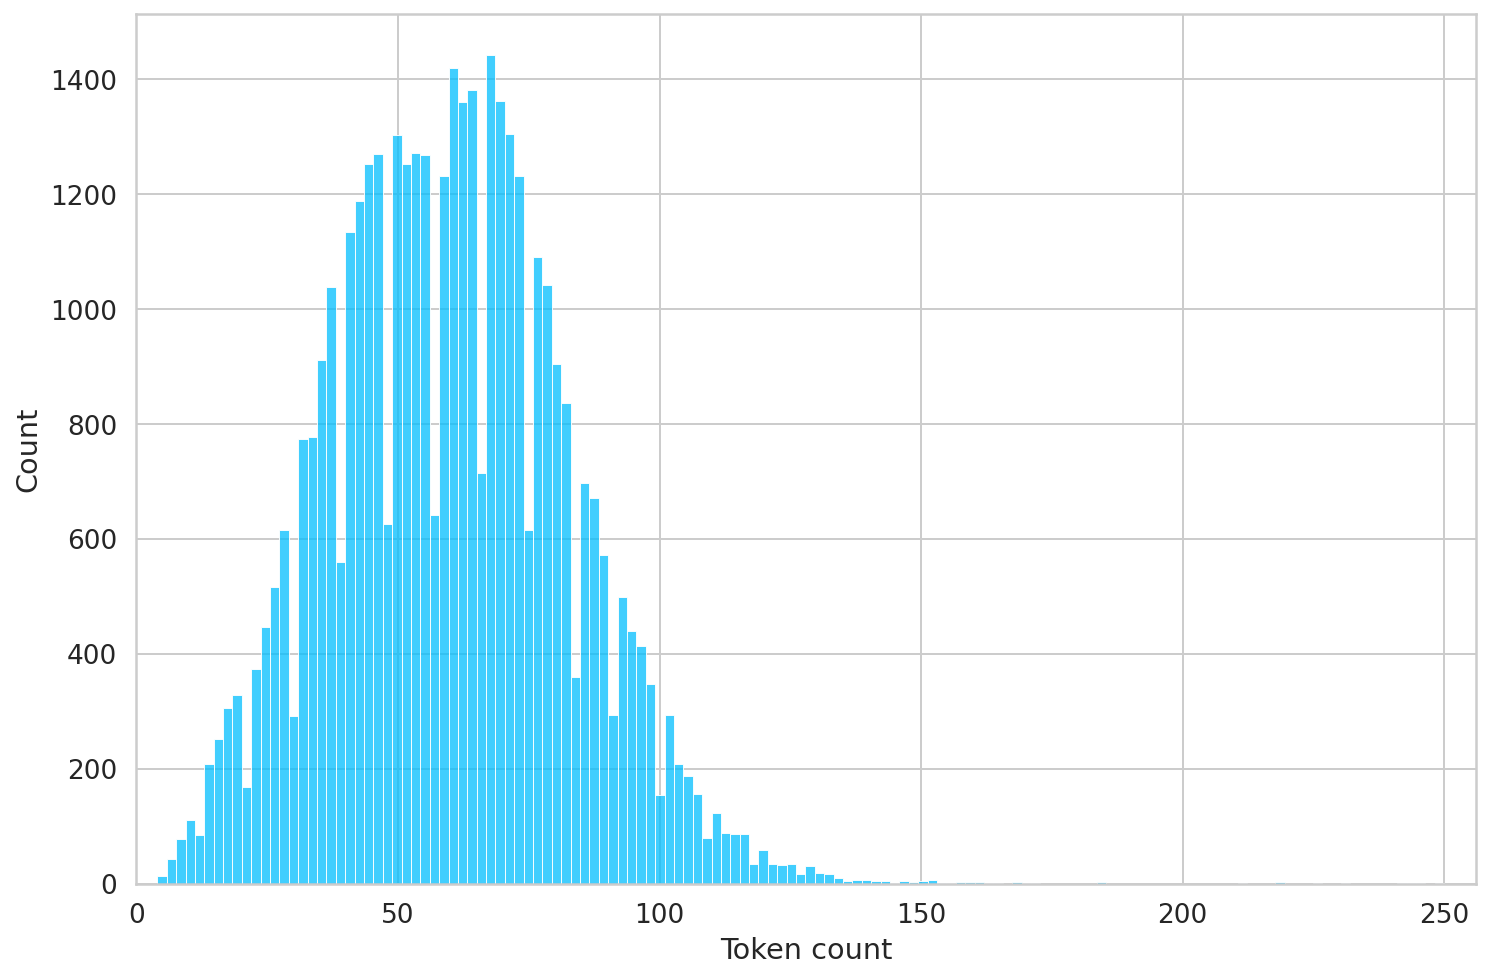

In [ ]:
token_lens = []

for txt in df['OriginalTweet']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.histplot(x = token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

## Creating the Dataset

In [ ]:
class CovidTweetDataset(Dataset):

  def __init__ (self, tweet, Class, tokenizer, max_len):
    self.tweet = tweet
    self.Class = Class
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweet)

  def __getitem__(self, item):
    tweet = str(self.tweet[item])
    Class = self.Class[item]

    encoding  = tokenizer.encode_plus(
      tweet,
      truncation = True,
      add_special_tokens = True,
      max_length = self.max_len,
      padding = 'max_length',
      return_attention_mask = True,
      return_token_type_ids = False,
      return_tensors = 'pt'
    )

    return {
        'tweet_text' : tweet,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'Class' : torch.tensor(Class, dtype = torch.long)
    }
  

def create_data_loader(df, tokenizer, batch_size, max_len):
  ds = CovidTweetDataset(
      tweet = df['OriginalTweet'].to_numpy(),
      Class = df['Class'].to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4,
      shuffle = True
  )

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Class
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,2
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,3
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,3
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,3
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0


###Splitting the data into train, test and validation

In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:
train_data_loader = create_data_loader(df, tokenizer, Batch_Size, Max_Length)
test_data_loader = create_data_loader(df_test, tokenizer, Batch_Size, Max_Length)
val_data_loader = create_data_loader(df_val, tokenizer, Batch_Size, Max_Length)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'Class'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['Class'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

#Sentiment Analysis

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


##Building a Sentiment Classifier

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    output = output.pooler_output
    output = self.drop(output)
    output = self.out(output)
    return self.softmax(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    correct_bias = False
)

total_steps = len(train_data_loader) * Epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)


In [ ]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  for d in data_loader:

    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["Class"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["Class"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [29]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(Epochs):
  print(f'Epoch {epoch + 1}/{Epochs}')
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/MyDrive/MLProject/best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------
Train loss 1.400824889778118 accuracy 0.5531978078345617
Val   loss 1.3201539516448975 accuracy 0.5826044703595724

Epoch 2/20
----------
Train loss 1.3018004731171984 accuracy 0.6670176291136849
Val   loss 1.2519490048866864 accuracy 0.6520894071914479

Epoch 3/20
----------
Train loss 1.247069350393468 accuracy 0.7279501093383008
Val   loss 1.210336418576943 accuracy 0.6909620991253644

Epoch 4/20
----------
Train loss 1.2147252056045472 accuracy 0.7652061229448449
Val   loss 1.2035483551579853 accuracy 0.7035957240038873

Epoch 5/20
----------
Train loss 1.202395396222412 accuracy 0.7791636294916444
Val   loss 1.178316053956054 accuracy 0.7269193391642371

Epoch 6/20
----------
Train loss 1.1892173493413485 accuracy 0.7942010204908075
Val   loss 1.148672364016836 accuracy 0.7541302235179785

Epoch 7/20
----------
Train loss 1.1768007926611042 accuracy 0.8079695472584434
Val   loss 1.15340251793233 accuracy 0.7512147716229348

Epoch 8/20
----------
Train loss 1.

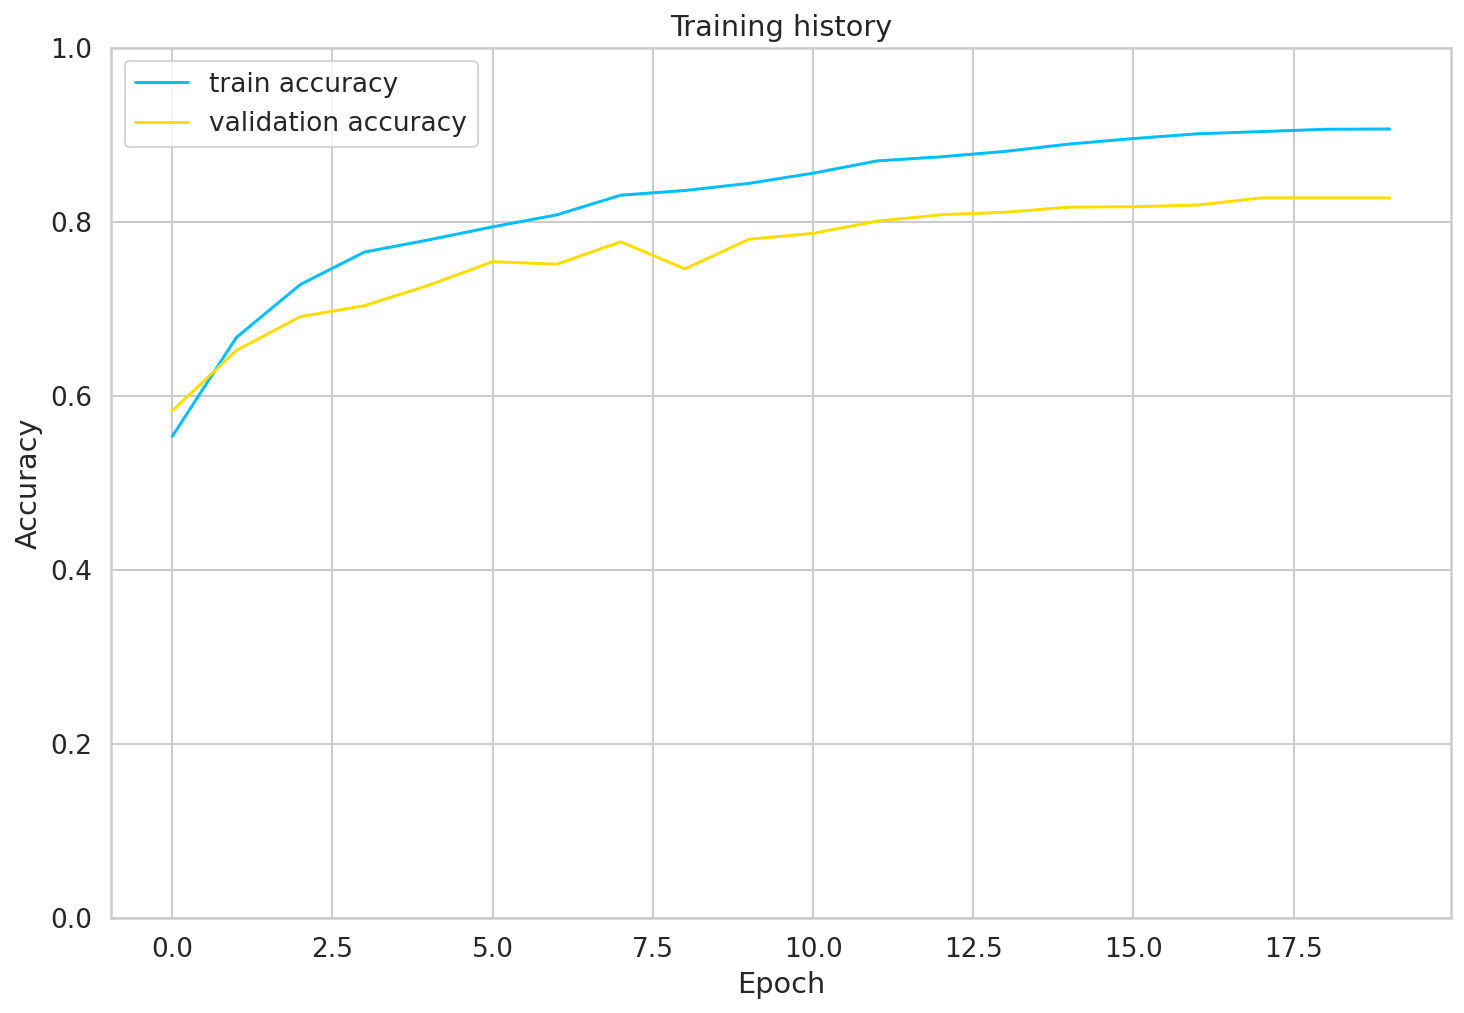

In [30]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);